In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Read the Data

In [2]:
data = pd.read_csv("train.csv")
data.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [3]:
future_data = pd.read_csv("future.csv").drop('Unnamed: 0' , axis = 1)
future_data.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,NaN
1,2022-08-01 01:00:00,NaN
2,2022-08-01 02:00:00,NaN
3,2022-08-01 03:00:00,NaN
4,2022-08-01 04:00:00,NaN


# Describe the Data

In [4]:
data.shape

(40152, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tarih                   40152 non-null  object 
 1   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1), object(1)
memory usage: 627.5+ KB


In [6]:
data['Tarih'] = pd.to_datetime(data['Tarih'])
future_data['Tarih'] = pd.to_datetime(future_data['Tarih'])
data.set_index('Tarih', inplace=True)
future_data.set_index('Tarih' , inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40152 entries, 2018-01-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1)
memory usage: 627.4 KB


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


# Plot the Data

# Modelling

## Train | Test Split

In [9]:
import tensorflow as tf

In [10]:
# Seed ayarlamak
seed_value = 34
tf.keras.utils.set_random_seed(seed_value)

In [11]:
X_test_temp = data.loc[data.index > '2022-07-23 23:00:00'].copy()
X_train_temp = data.loc[data.index <= '2022-07-23 23:00:00'].copy()

In [12]:
X_val_temp = X_train_temp[-96:]
X_train_temp = X_train_temp[:-96]

In [13]:
# X_train_temp.max()

In [14]:
# X_train_temp.min()

In [15]:
# X_val_temp.max()

In [16]:
# X_val_temp.min()

In [17]:
# X_test_temp.max()

In [18]:
# X_test_temp.min()

## Scaling

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
train_scaled = scaler.transform(X_train_temp)
test_scaled = scaler.transform(X_test_temp)

val_scaled = scaler.transform(X_val_temp)

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0,1))
# train_scaled = scaler.fit_transform(X_train_temp)
# test_scaled = scaler.transform(X_test_temp)

# val_scaled = scaler.transform(X_val_temp)

# Reshape

Bu işlemler zorunlu değil batch_generator zaten yapıyor bunu

In [21]:
def packager(train_scaled, val_scaled, test_scaled, window_size=24):
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    for i in range(window_size, len(train_scaled)):
        X_train.append(train_scaled[i-window_size:i, 0])
        y_train.append(train_scaled[i, 0])

    for i in range(window_size, len(val_scaled)):
        X_val.append(val_scaled[i-window_size:i, 0])
        y_val.append(val_scaled[i, 0])

    for i in range(window_size, len(test_scaled)):
        X_test.append(test_scaled[i-window_size:i, 0])
        y_test.append(test_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    X = np.concatenate((X_train, X_val, X_test), axis=0)
    y = np.concatenate((y_train, y_val, y_test), axis=0)

    return X_train, y_train, X_val, y_val, X_test, y_test, X, y

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test, X, y = packager(train_scaled, val_scaled, test_scaled)

In [23]:
X_train.shape

(39840, 24, 1)

In [24]:
X_test.shape

(168, 24, 1)

In [25]:
X_val.shape

(72, 24, 1)

In [26]:
X.shape

(40080, 24, 1)

In [27]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # Model oluşturma
# model = Sequential()
# model.add(LSTM(50, input_shape=(24, 1)))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

# # Veri jeneratörlerini oluşturma
# train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=24, batch_size=1)
# val_gen = TimeseriesGenerator(val_scaled, val_scaled, length=24, batch_size=1)
# test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=24, batch_size=1)

# # Modeli eğitme
# model.fit_generator(train_gen, epochs=10, validation_data=val_gen)

# # Modeli değerlendirme
# mse = model.evaluate_generator(test_gen)
# print('Test MSE: %.3f' % mse)

In [28]:
# predict_gen = TimeseriesGenerator(test_scaled[-24:], test_scaled[-24:], length=24, batch_size=1, end_index=len(test_scaled[-24:])-1)
# predictions = model.predict_generator(predict_gen, steps=31)
# predictions = scaler.inverse_transform(predictions)

In [29]:
# predict_gen = TimeseriesGenerator(test_scaled[-25:], test_scaled[-25:], length=24, batch_size=1)
# predictions = model.predict_generator(predict_gen, steps=31)
# predictions = scaler.inverse_transform(predictions)

In [30]:
# # Gelecek 31 günün 24 saatlik tahminleri için veri jeneratörü oluşturma
# # predict_gen = TimeseriesGenerator(test_scaled[-24:], test_scaled[-24:], length=24, batch_size=1)
# # predict_gen = TimeseriesGenerator(test_scaled[-24:], test_scaled[-24:], length=24, batch_size=1, start_index=0, end_index=len(test_scaled[-24:]) - 1)
# # predict_gen = TimeseriesGenerator(test_scaled[-24:], test_scaled[-24:], length=24, batch_size=1, end_index=len(test_scaled[-24:]))
# # predict_gen = TimeseriesGenerator(test_scaled[-24:], test_scaled[-24:], length=24, batch_size=1, end_index=len(test_scaled)-24)


# # Tahminleri yapma
# predictions = []
# for i in range(31*24):
#     x_input = predict_gen[0][0]
#     yhat = model.predict(x_input, verbose=0)
#     predictions.append(yhat[0][0])
#     x_input = np.append(x_input[:,1:,:], [[yhat[0]]], axis=1)
#     predict_gen = TimeseriesGenerator(x_input, np.zeros((1,1)), length=24, batch_size=1)

# # Tahminlerin ters ölçeklendirmesi
# predictions = np.array(predictions).reshape(-1, 1)
# predictions = scaler.inverse_transform(predictions)

# # Tahminleri yazdırma
# print(predictions)

In [31]:
# # Tahminleri yap
# predicted = model.predict(X_test)

# # Son 24 saatlik verileri al
# last_sequence = X_test[-1:]

# # Tahmin etmek için son 24 saatlik verileri kullanarak döngü
# forecast = []
# for i in range(31*24):
#     predicted_value = model.predict(last_sequence)
#     forecast.append(predicted_value[0,0])
    
#     # Tahmin edilen değeri alın ve son 23 saatlik verileri ile birleştirin
#     last_sequence = np.append(last_sequence[:,1:,:], [[predicted_value]], axis=1)
    
# # Tahminleri yazdır
# print(forecast)

# Eval Metric

In [32]:
def eval_metrics(y_true , y_pred):
    from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
    
    # MAPE hesaplama
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # r2 hesaplama
    r2 = r2_score(y_true , y_pred)
    
    # mae hesaplama
    mae = mean_absolute_error(y_true , y_pred)

    # rmse hesaplama
    mse = mean_squared_error(y_true,y_pred)**0.5
    
    print(f"""
          Mape Score : {mape}
          R2 Score : {r2}
          MAE Score : {mae}
          MSE Score : {mse}
          """)
    
def eval_plot(y_true , y_pred):
    tests = pd.DataFrame(data = y_true , columns=['Real Values'] , index = X_test[:-24].index)
    preds = pd.DataFrame(data = y_pred , columns=['Predicts'] , index = future_data[:-24].index)
    compare = pd.concat([tests[:-24], preds] , axis= 1)
    print(compare.plot())
    
def eval_df (y_true , y_pred):
    compare = pd.DataFrame({'Real Values': y_true, 'Predicts': y_pred}, index=future_data[:-24].index)
    print(compare)
    
def create_submission(future_preds, num):
    submission_df = pd.DataFrame({'Tarih': future_data.index, 'Dağıtılan Enerji (MWh)': future_preds})
    filename = 'submission{}.csv'.format(num)
    submission_df.to_csv(filename, index=False)
    globals()['submission{}'.format(num)] = submission_df

# Modelling Time

### Manual

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Model oluşturma
model = Sequential()
model.add(LSTM(50, input_shape=(24, 1), return_sequences= True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Modeli eğitme
model.fit(X_train , y_train, epochs= 10, validation_data=(X_val , y_val))

# Modeli değerlendirme
mse = model.evaluate(X_test , y_test)
print('Test MSE: %.3f' % mse)

### Automatic

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error
import numpy as np
import pandas as pd

In [ ]:
# Define the function for creating and training the LSTM model
def create_lstm_model(hidden_size, initial_num_unit, learning_rate, epoch=20, batch_size = 16 , look_back = 24 , unit_style= 'decrease' , save=False):
    if unit_style == "decrease":
        return_sequences = [True] * (hidden_size - 1) + [False]
        model = Sequential()
        for i in range(hidden_size):
            if i == 0:
                model.add(LSTM(initial_num_unit, input_shape=(look_back, 1), return_sequences=return_sequences[i]))
            else:
                model.add(LSTM(initial_num_unit // 2**i, return_sequences=return_sequences[i]))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        if save:
            return_sequences = [True] * (hidden_size - 1) + [False]
            model = Sequential()
            for i in range(hidden_size):
                if i == 0:
                    model.add(LSTM(initial_num_unit, input_shape=(look_back, 1), return_sequences=return_sequences[i]))
                else:
                    model.add(LSTM(initial_num_unit // 2**i, return_sequences=return_sequences[i]))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)
            
            
            sc = MinMaxScaler(feature_range=(0,1))
            train_scaled = sc.fit_transform(X_train_temp)
            test_scaled = sc.transform(X_test_temp)
            val_scaled = sc.transform(X_val_temp)
            
            packager(train_scaled , val_scaled , test_scaled)
            
            
            model.fit(X, y, epochs=epoch, batch_size=batch_size, verbose=1)
            y_pred = model.predict(X_test)
            org_y_pred = sc.inverse_transform(y_pred.reshape(-1,1))
            org_y_test = sc.inverse_transform(y_test.reshape(-1,1))
            
            testScore = mean_absolute_percentage_error(org_y_test, org_y_pred)
            
            model.save(f'../models/lstm_model_{hidden_size}_{initial_num_unit}_{learning_rate}_{epoch}_{round(testScore, 4)}.h5')
        else:
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch, batch_size=batch_size, verbose=1)
            return model
        
    elif unit_style == 'increase':
        return_sequences = [True] * (hidden_size - 1) + [False]
        model = Sequential()
        for i in range(hidden_size):
            if i == 0:
                model.add(LSTM(initial_num_unit, input_shape=(look_back, 1), return_sequences=return_sequences[i]))
            else:
                model.add(LSTM(initial_num_unit * 2**i, return_sequences=return_sequences[i]))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        if save:
            model.fit(X, y, epochs=epoch, batch_size=batch_size, verbose=1)
            model.save(f'../models/lstm_model_{hidden_size}_{initial_num_unit}_{learning_rate}_{epoch}.h5')
        else:
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch, batch_size=batch_size, verbose=1)
            return model
        
    elif unit_style == "same":
        return_sequences = [True] * (hidden_size - 1) + [False]
        model = Sequential()
        for i in range(hidden_size):
            if i == 0:
                model.add(LSTM(initial_num_unit, input_shape=(look_back, 1), return_sequences=return_sequences[i]))
            else:
                model.add(LSTM(initial_num_unit, return_sequences=return_sequences[i]))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        if save:
            model.fit(X, y, epochs=epoch, batch_size=batch_size, verbose=1)
            model.save(f'../models/lstm_model_{hidden_size}_{initial_num_unit}_{learning_rate}_{epoch}.h5')
        else:
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch, batch_size=batch_size, verbose=1)
            return model

In [ ]:
# Define empty lists to store model results
hidden_sizes = []
initial_units_list = []
learning_rates_list = []
epochs_list = []
train_scores = []
val_scores = []
test_scores = []

# Define hyperparameters to tune
hidden_layer_sizes = [2,3,4,5]
initial_num_units = [128,64,32,16]
learning_rates = [0.001, 0.01]
epochs = [5, 10, 20, 30]

# Define the number of epochs and batch size to use in training
batch_size = 1

# Define the number of previous time steps to use as input features
look_back = 24
        
        
for hidden_size in hidden_layer_sizes:
    for initial_num_unit in initial_num_units:
        for learning_rate in learning_rates:
            for epoch in epochs:
                print(f"Hidden size : {hidden_size} , Initial Num neurons : {initial_num_unit} , Learning Rate : {learning_rate} , Epoch : {epoch}")
                model = create_lstm_model(hidden_size, initial_num_unit, learning_rate , epoch = epoch , unit_style= 'decrease' )
                
                
                trainPredict = model.predict(X_train)
                valPredict = model.predict(X_val)
                testPredict = model.predict(X_test)
                org_y_train_pred = scaler.inverse_transform(trainPredict)
                org_y_val_pred = scaler.inverse_transform(valPredict)
                org_y_test_pred = scaler.inverse_transform(testPredict)
                
                org_y_train = scaler.inverse_transform(y_train.reshape(-1,1))
                org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
                org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))
                
                trainScore = mean_absolute_percentage_error(org_y_train, org_y_train_pred)
                valScore = mean_absolute_percentage_error(org_y_val, org_y_val_pred)
                testScore = mean_absolute_percentage_error(org_y_test_pred, org_y_test_pred)


                # Append results to lists
                hidden_sizes.append(hidden_size)
                initial_units_list.append(initial_num_unit)
                learning_rates_list.append(learning_rate)
                epochs_list.append(epoch)
                train_scores.append(trainScore)
                val_scores.append(valScore)
                test_scores.append(testScore)
                print(f"Hidden size : {hidden_size} , Initial Num neurons : {initial_num_unit} , Learning Rate : {learning_rate} , Epoch : {epoch} , Unit Style : {'Decrease'} ")
                print(f"Train Score : {trainScore} , Val Score : {valScore} , Test Score : {testScore}")
                print("--------------------------------------------------------------------------------")
                if testScore < 0.02 :
                    create_lstm_model(hidden_size , initial_num_unit , learning_rate , epoch = epoch, save= True)

# Create dataframe from results
results_df = pd.DataFrame({
    'HiddenSize': hidden_sizes,
    'Initial Num Neurons': initial_units_list,
    'LearningRate': learning_rates_list,
    'Epoch': epochs_list,
    'TrainScore': train_scores,
    'valScore': val_scores,
    'TestScore': test_scores
}).sort_values(by='TestScore' , ascending=False)

# Print dataframe
results_df.style.format("{:.2%}").background_gradient(cmap="Blues")
print(results_df)

In [ ]:
# Print dataframe
results_df.style.format("{:.2%}").background_gradient(cmap="Blues")
results_df

# Test-Evaluation

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\Emincan\Desktop\Gdz\models\lstm_model_2_16_0.01_5_0.013819644505614338.h5")

In [ ]:
# Inverse işlemini daha sonra hallet
# X_test_org = 
# y_test_org = 
# X_val_org = 
# y_val_org = 

In [ ]:
# print(model1.evaluate(X_test, y_test))
# model2.evaluate(X_test, y_test)

In [ ]:
# y_pred = model.predict(X_test)
# y_pred = y_pred.flatten()

In [ ]:
# y_pred

In [ ]:
# y_test

In [ ]:
# org_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(-1)
# org_y_pred

In [ ]:
# org_y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)
# org_y_test

In [ ]:
# eval_metrics(org_y_test , org_y_pred)

In [ ]:
# eval_plot(org_y_test , org_y_pred)

In [ ]:
# eval_df(org_y_test, org_y_pred)

# Final Model & Predictions

## Scaling

In [ ]:
# data

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# sc = MinMaxScaler(feature_range=(0,1))
# data_scaled = sc.fit_transform(data)

In [ ]:
# X.shape

## FINAL Model

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Model oluşturma
model = Sequential()
model.add(LSTM(16, input_shape=(24, 1) ,return_sequences = True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Modeli eğitme
model.fit(X , y, epochs=30, validation_data=(X_val , y_val))

# Modeli değerlendirme
mse = model.evaluate(X_test , y_test)
print('Test MSE: %.3f' % mse)

Epoch 1/30
1253/1253 [==============================] - 8s 4ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 2/30
1253/1253 [==============================] - 5s 4ms/step - loss: 6.8766e-04 - val_loss: 5.3453e-04
Epoch 3/30
1253/1253 [==============================] - 5s 4ms/step - loss: 5.2435e-04 - val_loss: 4.4371e-04
Epoch 4/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.9188e-04 - val_loss: 6.0326e-04
Epoch 5/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.8517e-04 - val_loss: 3.8040e-04
Epoch 6/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.6460e-04 - val_loss: 4.4983e-04
Epoch 7/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.6009e-04 - val_loss: 3.9375e-04
Epoch 8/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.4595e-04 - val_loss: 3.4180e-04
Epoch 9/30
1253/1253 [==============================] - 5s 4ms/step - loss: 4.3743e-04 - val_loss: 3.3311e-04
Epoch 10/30
1253/1

## Predicts

In [34]:
X[-1].shape

(24, 1)

In [35]:
# Elimizdeki verilerin son 24'ü bir sonraki tahmini yapmak için kullanılacak
last_window = X[-1]

# 31 gün boyunca tahminler yapmak için bir boş tahmin dizisi oluşturun
predictions = []

for i in range(31*24):
    # Tahmin edilen değerleri ölçeklendirmek için son pencereyi yeniden şekillendirin
    last_window_reshaped = last_window.reshape(1, 24, 1)

    # Son pencereyi kullanarak bir tahmin yapın
    prediction = model.predict(last_window_reshaped)[0][0]

    # Tahmini tahmin listesine ekleyin
    predictions.append(prediction)

    # Tahmin edilen değeri son pencerenin sonuna ekleyin
    last_window = np.append(last_window[1:], prediction)

# Tahminleri geri ölçeklendirin
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Tahminlerinizi burada kullanabilirsiniz

1/1 [==============================] - 0s 11ms/step


In [36]:
predictions

array([[2279.8035],
       [2157.793 ],
       [2025.8242],
       [1897.5333],
       [1789.0939],
       [1711.1184],
       [1667.3767],
       [1656.6578],
       [1689.324 ],
       [1807.9076],
       [2057.483 ],
       [2337.564 ],
       [2508.5488],
       [2615.591 ],
       [2642.0396],
       [2710.1768],
       [2766.3896],
       [2771.1218],
       [2733.212 ],
       [2645.8052],
       [2554.3647],
       [2501.1309],
       [2471.1396],
       [2409.89  ],
       [2305.3606],
       [2178.6506],
       [2041.4087],
       [1904.6567],
       [1788.5986],
       [1707.6509],
       [1664.067 ],
       [1655.9828],
       [1708.2094],
       [1891.3126],
       [2214.0154],
       [2472.6804],
       [2641.0447],
       [2719.9478],
       [2756.7444],
       [2842.6526],
       [2873.642 ],
       [2866.1772],
       [2816.6096],
       [2716.939 ],
       [2628.225 ],
       [2586.6074],
       [2555.572 ],
       [2480.1594],
       [2364.37  ],
       [2228.5662],


In [37]:
future_data['Dağıtılan Enerji (MWh)'] = predictions
future_data

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2279.803467
2022-08-01 01:00:00,2157.792969
2022-08-01 02:00:00,2025.824219
2022-08-01 03:00:00,1897.533325
2022-08-01 04:00:00,1789.093872
...,...
2022-08-31 19:00:00,3402.933105
2022-08-31 20:00:00,3275.424072
2022-08-31 21:00:00,3187.143311


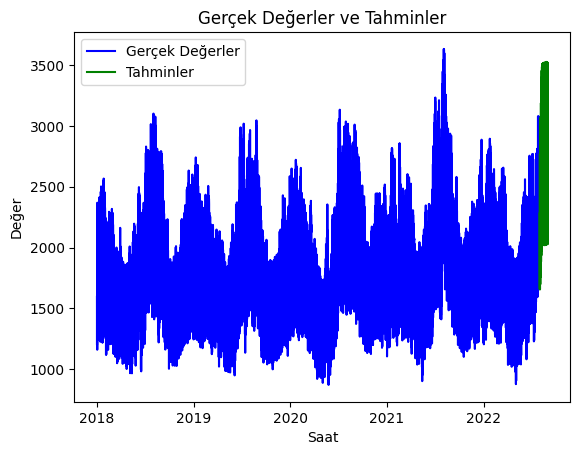

In [38]:
import matplotlib.pyplot as plt

# Gerçek değerleri mavi renkte çizdir
plt.plot(data, color='blue', label='Gerçek Değerler')

# Tahmin edilen değerleri yeşil renkte çizdir
plt.plot(future_data, color='green', label='Tahminler')

# Eksenleri ve grafik başlığını belirle
plt.title('Gerçek Değerler ve Tahminler')
plt.xlabel('Saat')
plt.ylabel('Değer')
plt.legend()

# Grafikleri göster
plt.show()

In [ ]:
# window_size = 24

# last_sequence = X[-24:]
# last_sequence = np.reshape(last_sequence, (24, window_size, 1))
# next_pred = model.predict(last_sequence , verbose = 0)


# # Gelecek 1 ayın tahmini
# prediction_list = []
# for i in range(31*24):
#     next_pred = model.predict(last_sequence , verbose = 0)
#     prediction_list.append(next_pred)
#     last_sequence = np.append(last_sequence[:,1:,:], [[next_pred]], axis=1)
    
# prediction_list = np.array(prediction_list).reshape(-1, 1)
# prediction_list = scaler.inverse_transform(prediction_list).reshape(-1)

In [ ]:
# model

In [ ]:
# window_size = 24

# # Girdi verilerini yeniden şekillendirin
# last_sequence = X[-window_size:]
# last_sequence = np.reshape(last_sequence, (1, window_size, 1))

# # Gelecek 1 ayın tahmini
# prediction_list = []
# for i in range(31*24):
#     next_pred = model.predict(last_sequence, verbose=0)
#     prediction_list.append(next_pred[0, 0]) # Tahmin edilen değeri listeye ekleyin
#     next_pred = np.reshape(next_pred, (1, 1, 1))
#     last_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred], axis=1)

# # Tahminleri yeniden şekillendirin ve ölçeklendirin
# prediction_list = np.array(prediction_list).reshape(-1, 1)
# prediction_list = scaler.inverse_transform(prediction_list)
# prediction_list = prediction_list.reshape(-1)

In [ ]:
# model.predict()

In [ ]:
# window_size = 24

# last_sequence = X[-24:]
# last_sequence = np.reshape(last_sequence, (24, window_size, 1))
# next_pred = model.predict(last_sequence , verbose = 0)

# # Gelecek 1 ayın tahmini
# prediction_list = []
# for i in range(31*24):
#     next_pred = model.predict(last_sequence , verbose = 0)
#     prediction_list.append(next_pred)
#     next_pred = np.reshape(next_pred, (24, 1, 1))
#     last_sequence = np.append(last_sequence[:,1:,:], next_pred, axis=1)
    
# prediction_list = np.array(prediction_list).reshape(-1, 1)
# prediction_list = scaler.inverse_transform(prediction_list).reshape(-1)

In [ ]:
# prediction_list[:]

In [ ]:
# create_submission(prediction_list , 3)

In [ ]:
# Done